In [15]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from LegalDocument import LegalDocument as LD
import re

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
root_path = './Банкротство'
subject_paths = ['Арбитражные управляющие',
                 'Особенности банкротства отдельных категорий должников',
                 'Упрощенные процедуры банкротства/Банкротство ликвидируемого должника',
                 'Упрощенные процедуры банкротства/Банкротство отсутствующего должника',
#                  'Общие положения',
                 'Процедуры банкротства/Мировое соглашение',
                 'Процедуры банкротства/Общие положения',
                 'Процедуры банкротства/Наблюдение',
                 'Процедуры банкротства/Внешнее управление',
                 'Процедуры банкротства/Конкурсное производство',
                ]
subject_paths = [os.path.join(root_path, subject_path) for subject_path in subject_paths]

document_collection_dict = [(subject_path.split('/')[-1], os.path.join(subject_path, document_name, list(filter(lambda x: x[-1]!='_', os.listdir(os.path.join(subject_path, document_name))))[0])) for subject_path in subject_paths for document_name in os.listdir(subject_path) if document_name!='.DS_Store']
document_collection = [document for (_, document) in document_collection_dict]

In [41]:
subjects_dict = {subject_paths[i].split('/')[-1] : i for i in range(len(subject_paths))}

In [17]:
l = [[(label, document) for (label, document) in document_collection_dict if label == subject_path.split('/')[-1]] for subject_path in subject_paths]
small_ds = [subject_docs[:100] for subject_docs in l]
# small_ds[5]
small_ds_dict = [(label, doc) for subject_docs in small_ds for (label, doc) in subject_docs ]
# document_collection = [doc in ]
small_ds_collection = [document for (_, document) in small_ds_dict]
document_collection = small_ds_collection
document_collection_dict = small_ds_dict

In [18]:
def get_text_from_file(document_name):
    soup = BeautifulSoup(open(document_name), "lxml")
    temp = soup.getText()[soup.getText().find('АРБИТРАЖНЫЙ СУД МОСКОВСКОГО ОКРУГА'):]
    text = temp[:temp.find('Документ предоставлен КонсультантПлюс')]
    return text

In [19]:
def get_ld_from_file(document_name):
    return LD(get_text_from_file(document_name))

In [20]:
# not_extracted = []
# extracted = []
# i=0
# for document_name in document_collection:
#     print(i)
#     print(document_name)
#     print('\nExtracted:')
#     print(LD.get_na_strings(get_text_from_file(document_name)))
#     print('\nEntities:')
#     print(LD(get_text_from_file(document_name)).na_list)
# #     print('\nWerent extracted:')
# #     for na_string in df[df['document']==document_name]['entity']:
# #         if na_string not in LG.get_na_strings(get_text_from_file(document_name)):
# #             not_extracted.append(na_string)
# #     print(not_extracted)
#     print('__________________________________________________')
#     i+=1

## Base code

In [21]:
import time
def timer(f):
    def tmp(*args, **kwargs):
        t = time.time()
        res = f(*args, **kwargs)
        with open('./log.txt', 'a+') as log:
            log.write("Время выполнения функции {}: {}\n".format(f.__name__, time.time()-t))
        return res
    return tmp

In [52]:
def rand_index(partition1, partition2):
    matrix_for_partition1 = [[element1==element2 for element1 in partition1] for element2 in partition1]
    matrix_for_partition2 = [[element1==element2 for element1 in partition2] for element2 in partition2]
    matrix_of_mistakes = [[matrix_for_partition1[i][j]==matrix_for_partition2[i][j] for j in range(len(matrix_for_partition1))] for i in range(len(matrix_for_partition2))]
    TP_plus_FN = len([element for row in matrix_of_mistakes for element in row if element])
    total = len(partition1) * len(partition2)
    return TP_plus_FN / total

In [23]:
import math
import numpy as np
from functools import reduce

@timer
def na_idf(ld_list, na):
    return math.log10(len(ld_list)/len([_ for ld in ld_list if na in ld.na_set]))

@timer
def get_tf_idf(doc_na_list, na_idfs, na):
    tf = doc_na_list.count(na)/len(doc_na_list)
    return tf * na_idfs[na]

@timer
def documents_to_vectors(document_collection):
    ld_list = [get_ld_from_file(document) for document in document_collection]
    na_set = reduce(lambda a, doc_na_set: a | doc_na_set, [ld.na_set for ld in ld_list])
    na_idfs = {na : na_idf(ld_list, na) for na in na_set}
    return np.array([[get_tf_idf(ld.na_list, na_idfs, na) for na in na_set] for ld in ld_list])

In [24]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import decomposition

doc_vec = documents_to_vectors(document_collection) #ставим в соответствие документам вектора

In [63]:
doc_vec_pcas = {}
for i in range(1,7):
    pca = decomposition.PCA(n_components=i*50)
    doc_vec_centered = doc_vec - doc_vec.mean(axis=0)
    pca.fit(doc_vec_centered)
    doc_vec_pcas.update({str(i*50) : pca.transform(doc_vec_centered)})
# len(doc_vec_pca['250'][0])

In [27]:
n_clusters = 40
model = KMeans(n_clusters=n_clusters)
model.fit(doc_vec_pca)
all_predictions = model.predict(doc_vec_pca)
doc_subjects = np.array([label for (label, _) in document_collection_dict])     #создаем список тематик документов
rand_index(all_predictions, doc_subjects)

0.7385851851851852

In [28]:
n_clusters = 40
model = KMeans(n_clusters=n_clusters)
model.fit(doc_vec)
all_predictions = model.predict(doc_vec)
doc_subjects = np.array([label for (label, _) in document_collection_dict])     #создаем список тематик документов
rand_index(all_predictions, doc_subjects)

0.5640197530864197

In [67]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.cluster import adjusted_rand_score as ari
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami

y_ariss = {}
y_amiss = {}

for doc_vec_pca_key in doc_vec_pcas.keys():
    y_aris=[]
    y_amis=[]
    for i in tqdm(range(10)):
        y_ri=[]
        y_ari=[]
        y_ami=[]
        for n_clusters in range(9,60):
            model = KMeans(n_clusters=n_clusters)
            model.fit(doc_vec_pca[doc_vec_pca_key])
            all_predictions = model.predict(doc_vec_pcas[doc_vec_pca_key])
            doc_subjects = np.array([subjects_dict[label] for (label, _) in document_collection_dict])     #создаем список тематик документов
            y_ari.append(ari(all_predictions, doc_subjects))
            y_ami.append(ami(all_predictions, doc_subjects))
        y_aris.append(y_ari)
        y_amis.append(y_ami)
    y_ariss.update({doc_vec_pca_key: y_aris})
    y_amiss.update({doc_vec_pca_key: y_amis})

100%|██████████| 10/10 [02:56<00:00, 17.66s/it]


50


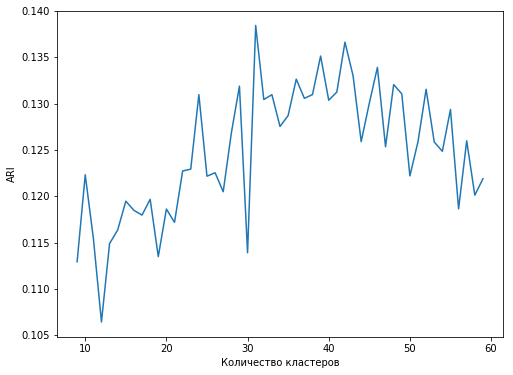

100


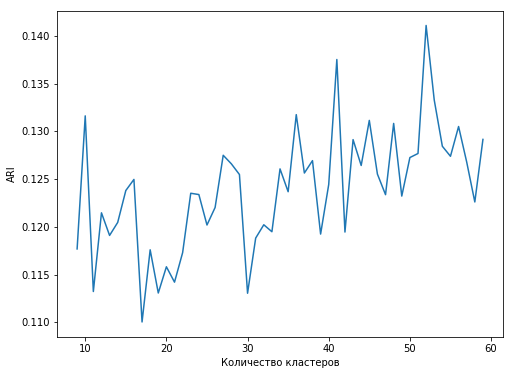

150


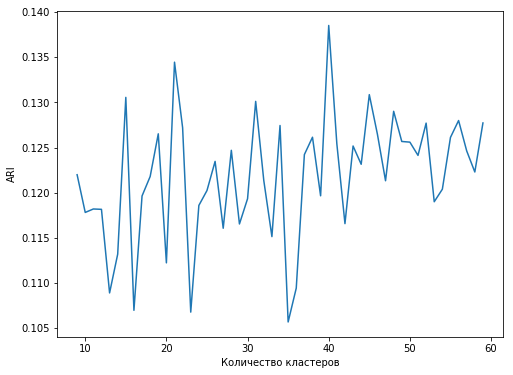

200


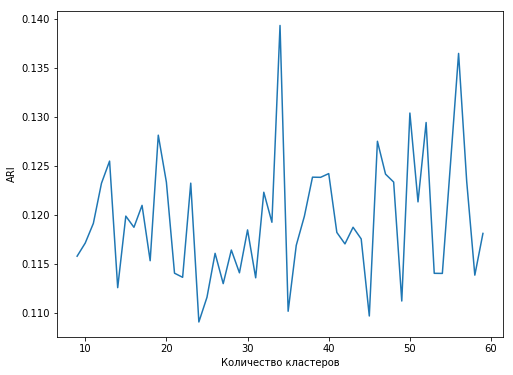

250


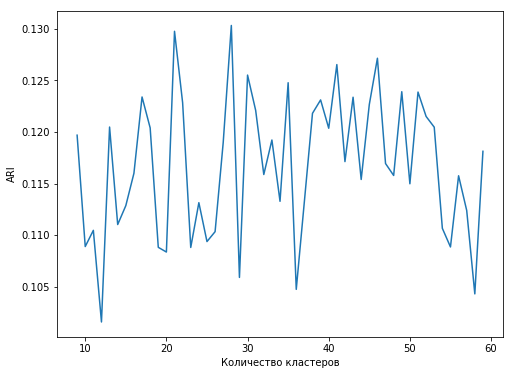

300


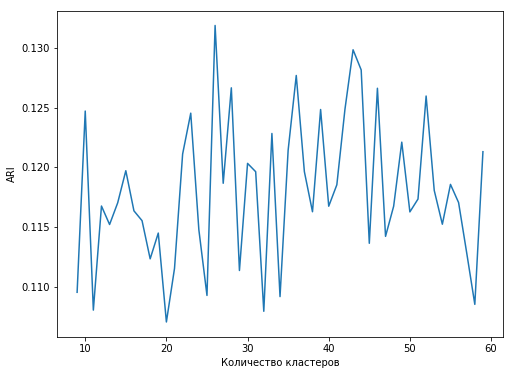

50


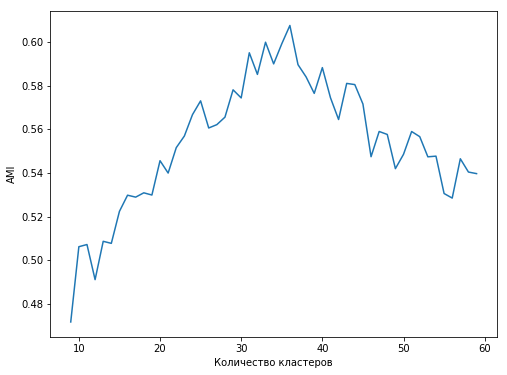

100


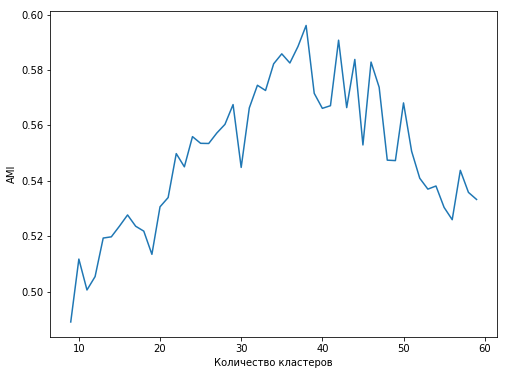

150


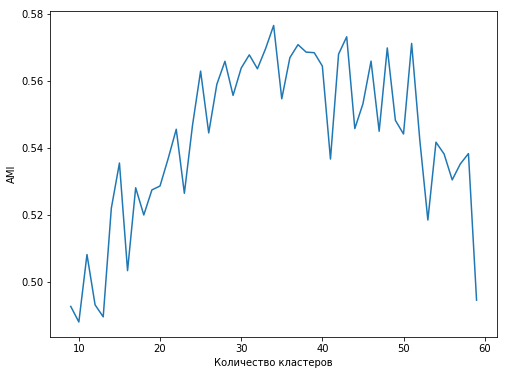

200


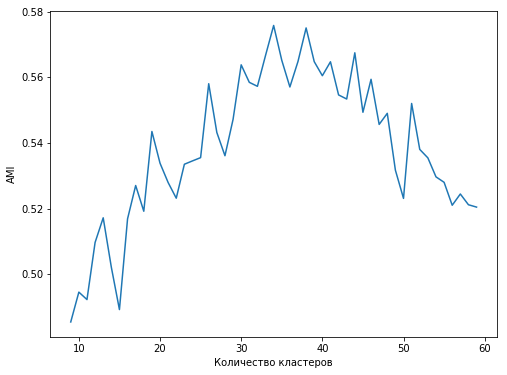

250


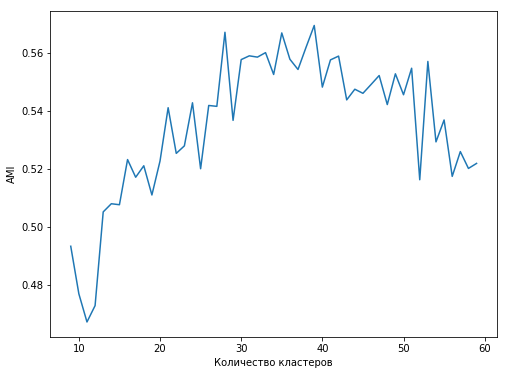

300


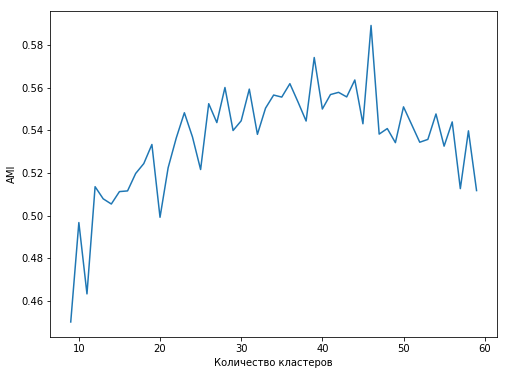

In [68]:
for y_aris_key in y_ariss.keys():
    print(y_aris_key)
    fig = plt.figure(figsize=(8, 6))
    plt.plot([n_clusters for n_clusters in range(9,60)], sum(np.array(y_ariss[y_aris_key]))/len(ys))
    plt.xlabel('Количество кластеров')
    plt.ylabel('ARI')
    plt.show()

for y_amis_key in y_amiss.keys():
    print(y_amis_key)
    fig = plt.figure(figsize=(8, 6))
    plt.plot([n_clusters for n_clusters in range(9,60)], sum(np.array(y_amiss[y_amis_key]))/len(ys))
    plt.xlabel('Количество кластеров')
    plt.ylabel('AMI')
    plt.show()

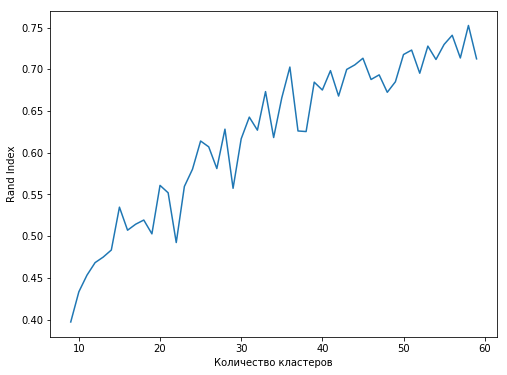

In [75]:
fig = plt.figure(figsize=(8, 6))
plt.plot([n_clusters for n_clusters in range(9,60)], sum(np.array(ys))/len(ys))
plt.xlabel('Количество кластеров')
plt.ylabel('Rand Index')
plt.show() #попробовать другие метрики и про них написать
#сингулярное разложение
#проверить свойства как у wordtovec
#Russian Bills

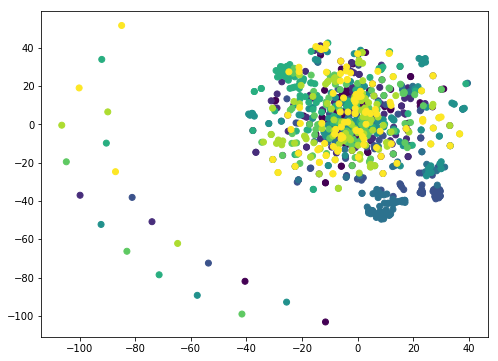

In [76]:
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
 
model = TSNE(learning_rate=100)
transformed = model.fit_transform(doc_vec)
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
 
doc_subjects = np.array([label for (label, _) in document_collection_dict])     #создаем список тематик документов
fig = plt.figure(figsize=(8, 6))
plt.scatter(x_axis, y_axis, c=res)
plt.show()

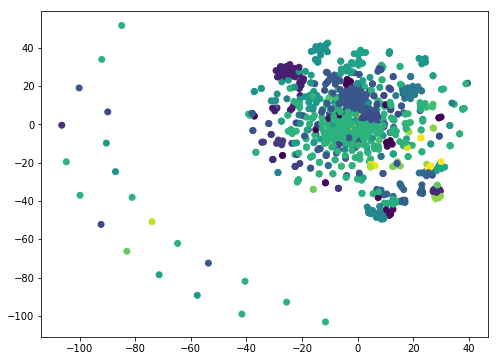

In [77]:
model = KMeans(n_clusters=60)
model.fit(doc_vec)
all_predictions = model.predict(doc_vec)
fig = plt.figure(figsize=(8, 6))
plt.scatter(x_axis, y_axis, c=all_predictions)
plt.show()

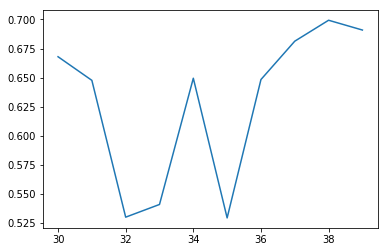

In [53]:
# plt.plot([n_clusters for n_clusters in range(9,30)], sum(np.array(ys))/len(ys[0]))
plt.plot([n_clusters for n_clusters in range(30,40)], sum(np.array(ys))/len(ys))

In [27]:
doc_subjects = np.array([label for (label, _) in document_collection_dict])     #создаем список тематик документов
print('Rand Index score: {}'.format(rand_index(all_predictions, doc_subjects))) #сравниваем его со списком кластеров документов

Rand Index score: 0.4644691358024691
